In [19]:
# Cell 1: imports and small utilities
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib

# helper: print nice section headers
def header(msg):
    print("\n" + "="*8 + " " + msg + " " + "="*8)

# ensure reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [20]:
# Cell 2: find CSVs under repo and set RAW_PATH to the one you want
header("Working directory and CSV search")
print("cwd:", os.getcwd())
files = glob.glob("../**/*.csv", recursive=True) + glob.glob("./**/*.csv", recursive=True)
files = sorted(set(files))
print("CSV files found:")
for f in files:
    print(" -", f)

# Choose your raw file path (update if needed)
RAW_PATH = "../data/raw/PS_2026.02.07_05.49.41.csv"   # <-- change this if needed
print("\nUsing RAW_PATH:", RAW_PATH)


======== Working directory and CSV search ========
cwd: c:\Users\shish\Desktop\B13-ExoHabitAI\notebooks
CSV files found:
 - ..\data\preprocessed\preprocessed.csv
 - ..\data\raw\PS_2026.02.07_05.49.41.csv

Using RAW_PATH: ../data/raw/PS_2026.02.07_05.49.41.csv


In [23]:
# Cell 3: load raw CSV robustly
header("Load CSV")
if not os.path.exists(RAW_PATH):
    raise FileNotFoundError(f"Raw file not found: {RAW_PATH}")

# Try using pandas with comment='#' to skip header notes
raw_df = pd.read_csv(RAW_PATH, comment='#', skipinitialspace=True, low_memory=False)
print("Raw shape:", raw_df.shape)
# show top columns / first row
display(raw_df.head(6))


======== Load CSV ========
Raw shape: (39315, 289)


,rowid,pl_name,hostname,pl_letter,hd_name,hip_name,tic_id,gaia_dr2_id,gaia_dr3_id,default_flag,...,rowupdate,pl_pubdate,releasedate,pl_nnotes,st_nphot,st_nrvc,st_nspec,pl_nespec,pl_ntranspec,pl_ndispec
0,1,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,Gaia DR3 3946945413106333696,1,...,2023-09-19,2023-08,2023-09-19,2.0,1.0,2.0,0.0,0.0,0.0,0.0
1,2,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,Gaia DR3 3946945413106333696,0,...,2014-05-14,2008-01,2014-05-14,2.0,1.0,2.0,0.0,0.0,0.0,0.0
2,3,11 Com b,11 Com,b,HD 107383,HIP 60202,TIC 72437047,Gaia DR2 3946945413106333696,Gaia DR3 3946945413106333696,0,...,2014-07-23,2011-08,2014-07-23,2.0,1.0,2.0,0.0,0.0,0.0,0.0
3,4,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,Gaia DR3 1696798367260229376,1,...,2018-09-04,2017-03,2018-09-06,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,5,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,Gaia DR3 1696798367260229376,0,...,2018-04-25,2011-08,2014-07-23,0.0,1.0,1.0,0.0,0.0,0.0,0.0
5,6,11 UMi b,11 UMi,b,HD 136726,HIP 74793,TIC 230061010,Gaia DR2 1696798367260229376,Gaia DR3 1696798367260229376,0,...,2018-04-25,2009-10,2014-05-14,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [24]:
# Cell 4: quick diagnostics
header("Quick diagnostics")
print("Columns:", len(raw_df.columns))
print("Row count:", len(raw_df))
print("Memory usage (MB):", raw_df.memory_usage(deep=True).sum() / 1024**2)
print("Preview column names (first 60):")
print(raw_df.columns[:60].tolist())


======== Quick diagnostics ========
Columns: 289
Row count: 39315
Memory usage (MB): 155.44463539123535
Preview column names (first 60):
['rowid', 'pl_name', 'hostname', 'pl_letter', 'hd_name', 'hip_name', 'tic_id', 'gaia_dr2_id', 'gaia_dr3_id', 'default_flag', 'sy_snum', 'sy_pnum', 'sy_mnum', 'cb_flag', 'discoverymethod', 'disc_year', 'disc_refname', 'disc_pubdate', 'disc_locale', 'disc_facility', 'disc_telescope', 'disc_instrument', 'rv_flag', 'pul_flag', 'ptv_flag', 'tran_flag', 'ast_flag', 'obm_flag', 'micro_flag', 'etv_flag', 'ima_flag', 'dkin_flag', 'soltype', 'pl_controv_flag', 'pl_refname', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_radelim', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2', 'pl_radjlim', 'pl_masse', 'pl_masseerr1', 'pl_masseerr2', 'pl_masselim', 'pl_massj', 'pl_massjerr1', 'pl_massjerr2', 'pl_massjlim', 'pl_msinie']


In [ ]:
# Cell 5: expected feature list (map these to your CSV's column names)
# Edit the names here to match your dataset's column names if they differ.
required_cols = {
    "pl_name":"pl_name",
    "pl_rade": "pl_rade",   # planet radius (Earth radii) - change if column is named differently
    "pl_bmasse": "pl_bmasse", # planet mass (Earth masses)
    "pl_orbper": "pl_orbper", # orbital period (days)
    "pl_orbsmax": "pl_orbsmax", # semi-major axis (AU)
    "pl_eqt": "pl_eqt",     # equilibrium temperature (K)
    "pl_dens": "pl_dens",   # planet density
    "st_teff": "st_teff",   # host star temperature (K)
    "st_lum": "st_lum",     # star luminosity
    "st_met": "st_met",     # star metallicity
    "st_spectype": "st_spectype"  # star type (categorical)
}
# Keep only those columns that exist in raw_df (avoid KeyError)
existing = [v for v in required_cols.values() if v in raw_df.columns]
print("Requested features mapping:")
for k,v in required_cols.items():
    print(f"  {k} -> {v} {'(FOUND)' if v in raw_df.columns else '(MISSING)'}")
print("\nSelecting columns that exist:", existing)
df = raw_df.copy()[existing]
print("Selected shape:", df.shape)
display(df.head(3))

Requested features mapping:
  pl_rade -> pl_rade (FOUND)
  pl_bmasse -> pl_bmasse (FOUND)
  pl_orbper -> pl_orbper (FOUND)
  pl_orbsmax -> pl_orbsmax (FOUND)
  pl_eqt -> pl_eqt (FOUND)
  pl_dens -> pl_dens (FOUND)
  st_teff -> st_teff (FOUND)
  st_lum -> st_lum (FOUND)
  st_met -> st_met (FOUND)
  st_spectype -> st_spectype (FOUND)

Selecting columns that exist: ['pl_rade', 'pl_bmasse', 'pl_orbper', 'pl_orbsmax', 'pl_eqt', 'pl_dens', 'st_teff', 'st_lum', 'st_met', 'st_spectype']
Selected shape: (39315, 10)


,pl_rade,pl_bmasse,pl_orbper,pl_orbsmax,pl_eqt,pl_dens,st_teff,st_lum,st_met,st_spectype
0,NaN,4914.898486,323.21,1.178,NaN,NaN,4874.0,1.97823,-0.26,G8 III
1,NaN,6165.600000,326.03,1.290,NaN,NaN,4742.0,2.24300,-0.35,G8 III
2,NaN,5434.700000,NaN,1.210,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
print("\n===== Duplicate removal (by planet name) =====")

pid = 'pl_name'

if pid in df.columns:
    before = len(df)

    important_cols = ['pl_rade','pl_bmasse','pl_orbper','pl_orbsmax','pl_eqt','st_teff']
    df['null_count'] = df[important_cols].isnull().sum(axis=1)

    df = (
        df.sort_values([pid, 'null_count'])
          .drop_duplicates(subset=[pid], keep='first')
          .drop(columns='null_count')
          .reset_index(drop=True)
    )

    after = len(df)
    print(f"Removed {before - after} duplicate rows")

else:
    before = len(df)
    df = df.drop_duplicates().reset_index(drop=True)
    print(f"Removed {before - len(df)} exact duplicates")

print("Current df shape:", df.shape)


===== Duplicate removal (by planet name) =====
Removed 5584 exact duplicates
Current df shape: (33731, 10)


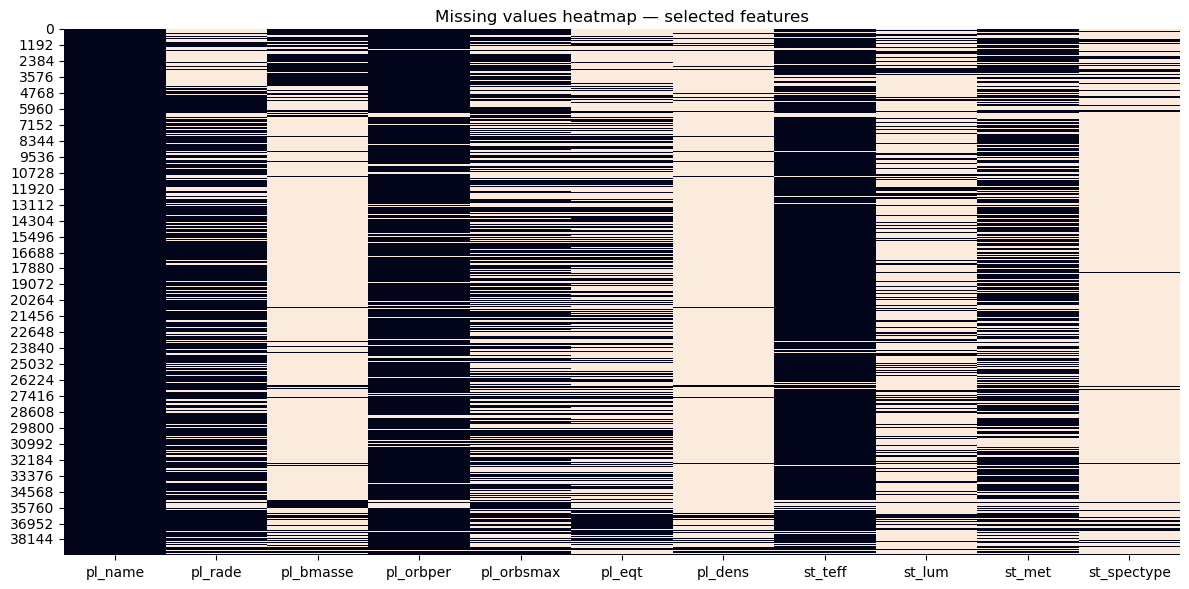

In [8]:
# Cell 7 — Missing value heatmap (visual)
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing values heatmap — selected features")
plt.tight_layout()
plt.show()

In [9]:
# Cell 8 — Remove duplicates & drop extremely sparse columns
before_rows = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
print(f"Duplicates removed: {before_rows - df.shape[0]}  -> new shape {df.shape}")

threshold = 0.85
cols_to_drop = df.columns[df.isnull().mean() > threshold].tolist()
print("Dropping columns with >85% missing:", cols_to_drop)
df = df.drop(columns=cols_to_drop)
print("Shape after dropping high-missing columns:", df.shape)

Duplicates removed: 5498  -> new shape (33817, 11)
Dropping columns with >85% missing: ['pl_dens', 'st_spectype']
Shape after dropping high-missing columns: (33817, 9)


In [10]:
# Cell 9 — Imputation: numeric median, categorical mode
df = df.dropna(how='all').reset_index(drop=True)   # drop fully empty rows

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numeric cols:", numeric_cols)
print("Categorical cols:", cat_cols)

if numeric_cols:
    num_imp = SimpleImputer(strategy='median')
    df[numeric_cols] = num_imp.fit_transform(df[numeric_cols])

for c in cat_cols:
    mode_val = df[c].mode().iloc[0] if not df[c].mode().empty else "Unknown"
    df[c] = df[c].fillna(mode_val)

print("Remaining missing values total:", df.isnull().sum().sum())

Numeric cols: ['pl_rade', 'pl_bmasse', 'pl_orbper', 'pl_orbsmax', 'pl_eqt', 'st_teff', 'st_lum', 'st_met']
Categorical cols: ['pl_name']
Remaining missing values total: 0


In [11]:
# Cell 10 — Outlier handling: IQR cap (winsorize) then Z-score removal
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Applying outlier handling to:", num_cols)

# IQR-based cap (01-99 percentile)
def cap_iqr(series, low_q=0.01, high_q=0.99):
    lo = series.quantile(low_q)
    hi = series.quantile(high_q)
    return series.clip(lower=lo, upper=hi)

for col in num_cols:
    if df[col].dropna().empty:
        continue
    df[col] = cap_iqr(df[col])

# Z-score removal (strict)
if num_cols:
    z = np.abs(stats.zscore(df[num_cols], nan_policy='omit'))
    if z.ndim == 1:
        mask = z < 4
    else:
        mask = (z < 4).all(axis=1)
    removed = (~mask).sum()
    df = df[mask].reset_index(drop=True)
    print(f"Rows removed by Z-score (>4): {removed} -> new shape {df.shape}")

# Remove obvious impossible physical values (negative radius/mass/temps)
if 'pl_rade' in df.columns:
    before = df.shape[0]; df = df[df['pl_rade'] > 0].reset_index(drop=True); print("Removed pl_rade<=0:", before-df.shape[0])
if 'pl_bmasse' in df.columns:
    before = df.shape[0]; df = df[df['pl_bmasse'] > 0].reset_index(drop=True); print("Removed pl_bmasse<=0:", before-df.shape[0])
if 'pl_eqt' in df.columns:
    before = df.shape[0]; df = df[(df['pl_eqt'] > 0) & (df['pl_eqt'] < 1e4)].reset_index(drop=True); print("Removed invalid pl_eqt:", before-df.shape[0])

Applying outlier handling to: ['pl_rade', 'pl_bmasse', 'pl_orbper', 'pl_orbsmax', 'pl_eqt', 'st_teff', 'st_lum', 'st_met']
Rows removed by Z-score (>4): 2399 -> new shape (31418, 9)
Removed pl_rade<=0: 0
Removed pl_bmasse<=0: 0
Removed invalid pl_eqt: 0


In [12]:
# Cell 11 — Unit standardization (verify / convert if needed)
# By default NASA Exoplanet Archive uses Earth radii, Earth masses, AU, Kelvin.
print("Assuming units: radius=Earth radii, mass=Earth masses, distance=AU, temp=Kelvin")

# If your raw file has other columns (example shown), uncomment and adapt:
# if 'pl_radj' in raw_df_copy.columns and 'pl_rade' not in df.columns:
#     df['pl_rade'] = raw_df_copy['pl_radj'] * 11.209   # Jupiter radii -> Earth radii
# if 'pl_bmassj' in raw_df_copy.columns and 'pl_bmasse' not in df.columns:
#     df['pl_bmasse'] = raw_df_copy['pl_bmassj'] * 317.8  # Jupiter mass -> Earth masses

Assuming units: radius=Earth radii, mass=Earth masses, distance=AU, temp=Kelvin


In [13]:
# Cell 12 — Feature engineering (physics-based proxies)
def temp_score(temp_k, t_min=273.15, t_max=323.15):
    t = np.array(temp_k, dtype=float)
    score = np.zeros_like(t, dtype=float)
    inside = (t >= t_min) & (t <= t_max)
    score[inside] = 1.0
    below = t < t_min; above = t > t_max
    score[below] = np.exp(-((t_min - t[below]) / 50.0)**2)
    score[above] = np.exp(-((t[above] - t_max) / 50.0)**2)
    return score

def radius_score(r):
    r = np.array(r, dtype=float)
    return np.exp(-((r - 1.0)/0.5)**2)

def irradiance_score(a_au, L):
    a = np.array(a_au, dtype=float); L = np.array(L, dtype=float)
    irr = L / (a**2 + 1e-12)
    irr_scaled = irr / (np.nanmedian(irr) if np.nanmedian(irr) != 0 else 1)
    return np.exp(-((np.log10(irr_scaled + 1e-12))**2) / (2 * (0.5**2)))

df['score_temp'] = temp_score(df['pl_eqt']) if 'pl_eqt' in df.columns else 0.5
df['score_radius'] = radius_score(df['pl_rade']) if 'pl_rade' in df.columns else 0.5
df['score_distance'] = irradiance_score(df['pl_orbsmax'], df['st_lum']) if ('pl_orbsmax' in df.columns and 'st_lum' in df.columns) else 0.5

weights = {'temp':0.35,'radius':0.35,'distance':0.30}
df['habitability_score'] = weights['temp']*df['score_temp'] + weights['radius']*df['score_radius'] + weights['distance']*df['score_distance']

df['stellar_compatibility'] = np.exp(-((df['st_teff'] - 5778)/1000.0)**2) if 'st_teff' in df.columns else 0.5
df['orbital_stability'] = 1.0 / (1.0 + np.abs(np.log10((df['pl_orbper'] / (365.0 * (df['pl_orbsmax']**1.5)))+1e-12))) if ('pl_orbper' in df.columns and 'pl_orbsmax' in df.columns) else 0.5

print("Engineered features added.")


Engineered features added.


C:\Users\shish\AppData\Local\Temp\ipykernel_11740\845445660.py:20: RuntimeWarning: invalid value encountered in log10
  return np.exp(-((np.log10(irr_scaled + 1e-12))**2) / (2 * (0.5**2)))


In [14]:
# Cell 13 — Categorical encoding: spectral class (G,K,M,F,...)
if 'st_spectype' in df.columns:
    df['spectral_class'] = df['st_spectype'].astype(str).str.strip().str.upper().str[0]
    df['spectral_class'] = df['spectral_class'].where(df['spectral_class'].isin(list("OBAFGKM")), "X")
    spec_dummies = pd.get_dummies(df['spectral_class'], prefix='spec', drop_first=False)
    df = pd.concat([df, spec_dummies], axis=1)
    print("Added spectral one-hot columns:", [c for c in df.columns if c.startswith('spec_')])
else:
    print("No st_spectype present; skipping categorical encoding.")

No st_spectype present; skipping categorical encoding.


In [15]:
# Cell 14 — Feature scaling
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# exclude target if already present
numeric_cols = [c for c in numeric_cols if c not in ('habitable_binary',)]
print("Numeric columns to scale:", numeric_cols)

scaler = StandardScaler()
if numeric_cols:
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    joblib.dump(scaler, os.path.join(OUT_DIR, "scaler.joblib"))
    print("Scaler saved to", os.path.join(OUT_DIR, "scaler.joblib"))

Numeric columns to scale: ['pl_rade', 'pl_bmasse', 'pl_orbper', 'pl_orbsmax', 'pl_eqt', 'st_teff', 'st_lum', 'st_met', 'score_temp', 'score_radius', 'score_distance', 'habitability_score', 'stellar_compatibility', 'orbital_stability']
Scaler saved to ../data/preprocessed\scaler.joblib


In [16]:
# Cell 15 — Create binary target & final checks
if 'habitability_score' in df.columns:
    df['habitable_binary'] = (df['habitability_score'] >= 0.6).astype(int)
else:
    df['habitable_binary'] = ((df['pl_eqt'].between(200,350)) & (df['pl_rade'].between(0.5,2))).astype(int)

print("Target distribution:\n", df['habitable_binary'].value_counts(dropna=False))

print("\nFinal shape:", df.shape)
print("Total missing values:", df.isnull().sum().sum())
print("Duplicate rows remaining:", df.duplicated().sum())

Target distribution:
 habitable_binary
0    26691
1     4727
Name: count, dtype: int64

Final shape: (31418, 16)
Total missing values: 8098
Duplicate rows remaining: 59


In [18]:
# Reduce dataset size (recommended)
TARGET_ROWS = 10000

if len(df) > TARGET_ROWS:
    df = df.sample(n=TARGET_ROWS, random_state=42).reset_index(drop=True)
    print("Reduced dataset shape:", df.shape)
else:
    print("Dataset already small:", df.shape)

Reduced dataset shape: (10000, 16)
